# Data creation

In [1]:
import pandas as pd

df = pd.DataFrame({'ID':[1,2,3,4,5,6], 
                   'First Name':['Felix', 'Jean', 'James', 'Daphne', 'James', 'Peter'], 
                   'Family Name': ['Revert', 'Durand', 'Wright', 'Hull', 'Conrad', 'Donovan'],
                   'Phone number': ['+33 6 12 34 56 78', '+33 7 00 00 00 00', '+33 6 12 34 56 78', '+33 6 99 99 99 99', '+852 0123 4567', '+852 0123 4567'],
                   'Email': ['felix.revert@gmail.com', 'jean.durand@gmail.com', 'j.custom@gmail.com', pd.np.nan, 'j.custom@gmail.com', pd.np.nan]})


# G.add_nodes_from(df.ID.unique().tolist(), label='user')

# Data preparation

### Phone numbers

In [2]:
column_edge = 'Phone number'
column_ID = 'ID'

data_to_merge = df[[column_ID, column_edge]].dropna(subset=[column_edge]).drop_duplicates() # select columns, remove NaN

# To create connections between people who have the same number,
# join data with itself on the 'ID' column.
data_to_merge = data_to_merge.merge(
    data_to_merge[[column_ID, column_edge]].rename(columns={column_ID:column_ID+"_2"}), 
    on=column_edge
)

In [251]:
data_to_merge

,ID,Phone number,ID_2
0,1,+33 6 12 34 56 78,1
1,1,+33 6 12 34 56 78,3
2,3,+33 6 12 34 56 78,1
3,3,+33 6 12 34 56 78,3
4,2,+33 7 00 00 00 00,2
5,4,+33 6 99 99 99 99,4
6,5,+852 0123 4567,5
7,5,+852 0123 4567,6
8,6,+852 0123 4567,5
9,6,+852 0123 4567,6


In [3]:
# By joining the data with itself, people will have a connection with themselves.
# Remove self connections, to keep only connected people who are different.
d = data_to_merge[~(data_to_merge[column_ID]==data_to_merge[column_ID+"_2"])] \
    .dropna()[[column_ID, column_ID+"_2", column_edge]]
    
# To avoid counting twice the connections (person 1 connected to person 2 and person 2 connected to person 1)
# we force the first ID to be "lower" then ID_2
d.drop(d.loc[d[column_ID+"_2"]<d[column_ID]].index.tolist(), inplace=True)

In [253]:
d

,ID,ID_2,Phone number
1,1,3,+33 6 12 34 56 78
7,5,6,+852 0123 4567


### Creation of the graph

In [4]:
import networkx as nx

G = nx.from_pandas_edgelist(df=d, source=column_ID, target=column_ID+'_2', edge_attr=column_edge)

G.add_nodes_from(nodes_for_adding=df.ID.tolist())

In [255]:
G.nodes()

NodeView((1, 3, 5, 6, 2, 4))

### Emails

In [5]:
column_edge = 'Email'
column_ID = 'ID'

data_to_merge = df[[column_ID, column_edge]].dropna(subset=[column_edge]).drop_duplicates()

data_to_merge = data_to_merge.merge(
    data_to_merge[[column_ID, column_edge]].rename(columns={column_ID:column_ID+"_2"}), 
    on=column_edge
)

d = data_to_merge[~(data_to_merge[column_ID]==data_to_merge[column_ID+"_2"])] \
    .dropna()[[column_ID, column_ID+"_2", column_edge]]

d.drop(d.loc[d[column_ID+"_2"]<d[column_ID]].index.tolist(), inplace=True)

In [257]:
d

,ID,ID_2,Email
3,3,5,j.custom@gmail.com


In [6]:
# Create the connections in the graph
links_attributes = {tuple(row[[column_ID, column_ID+"_2"]]): {column_edge: row[column_edge]} for i,row in d.iterrows()}

G.add_edges_from(links_attributes) # create the connection, without attribute. Check it with G.get_edge_data(3,5)
nx.set_edge_attributes(G=G, values=links_attributes) # adds the attribute. Check it with G.get_edge_data(3,5)

# Graph analysis

### Drawing graphs

In [7]:
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


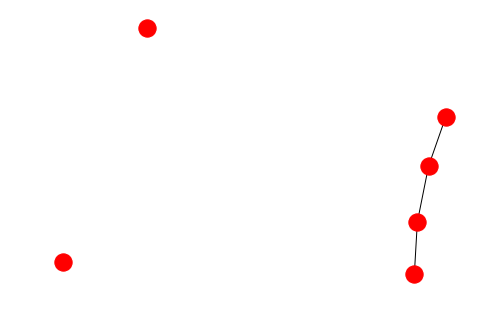

In [8]:
nx.draw(G)

In [9]:
{row[column_ID]:row['First Name'] +' '+ row['Family Name'] for i,row in df.iterrows()}

{1: 'Felix Revert',
 2: 'Jean Durand',
 3: 'James Wright',
 4: 'Daphne Hull',
 5: 'James Conrad',
 6: 'Peter Donovan'}

In [10]:
nx.set_node_attributes(G, {row[column_ID]:{'Name': row['First Name'] +' '+ row['Family Name']} for i,row in df.iterrows()})

In [357]:
EDGE_SIZE = {
    'Phone number': 2,
    'Email': 1,
}

EDGE_COLOR = {
    'Phone number': 'purple',
    'Email': 'red',
}

def clean_edge(edge):
    s.edge[edge[0], edge[1]].values()

def c_(list_edges): return [a for a in list_edges if a in list(EDGE_COLOR.keys())]
    
# For nx.Graph()
def edge_sizes(s): return [EDGE_SIZE[c_(list(s.edges[edge[0], edge[1]].keys()))[-1]] for edge in s.edges()] # /!\ multiple links => one size
def edge_colors(s): return [EDGE_COLOR[c_(list(s.edges[edge[0], edge[1]].keys()))[-1]] for edge in s.edges()] # /!\ multiple links => one color

# For nx.MultiDiGraph()
# def edge_sizes(s): return [EDGE_SIZE[s.edge[edge[0]][edge[1]][0]['label']] for edge in s.edges()] # /!\ multiple links => one size
# def edge_colors(s): return [EDGE_COLOR[s.edge[edge[0]][edge[1]][0]['label']] for edge in s.edges()] # /!\ multiple links => one color

def draw(s):
    pos = nx.spring_layout(s, scale=0.5)
    node_labels = dict((n,d['Name']) for n,d in s.nodes(data=True))
#     labels = {**node_labels, **edge_labels}
    nx.draw(s, pos=pos, width=edge_sizes(s), edge_color=edge_colors(s), alpha=0.8, arrows=False, node_color='lightgrey', node_size=400,
            labels=node_labels, 
            font_color='black', font_size=8, font_weight='bold',
           )
    edge_labels = dict(((u,v),list(d.values())[0]) for u,v,d in G.edges(data=True))
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size=8)

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


{(1, 3): Text(-0.24392292851812414, -0.11735080049439042, '+33 6 12 34 56 78'),
 (3,
  5): Text(-0.2218326971922504, 0.0004736503445032028, 'j.custom@gmail.com'),
 (5, 6): Text(-0.2270439263205962, 0.12014914432097049, '+852 0123 4567')}

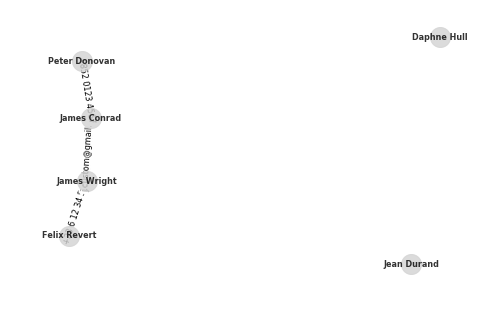

In [17]:
EDGE_SIZE = {
    'Phone number': 2,
    'Email': 1,
}

EDGE_COLOR = {
    'Phone number': 'purple',
    'Email': 'red',
}
pos = nx.spring_layout(G, scale=0.5)
node_labels = dict((n,d['Name']) for n,d in G.nodes(data=True))
#     labels = {**node_labels, **edge_labels}
def clean_edge(edge):
    G.edge[edge[0], edge[1]].values()
def c_(list_edges): return [a for a in list_edges if a in list(EDGE_COLOR.keys())]
# For nx.Graph()
def edge_sizes(G): return [EDGE_SIZE[c_(list(G.edges[edge[0], edge[1]].keys()))[-1]] for edge in G.edges()] # /!\ multiple links => one size
def edge_colors(G): return [EDGE_COLOR[c_(list(G.edges[edge[0], edge[1]].keys()))[-1]] for edge in G.edges()] # /!\ multiple links => one color

nx.draw(G, pos=pos, width=edge_sizes(G), edge_color=edge_colors(G), alpha=0.8, arrows=False, node_color='lightgrey', node_size=400,
            labels=node_labels, 
            font_color='black', font_size=8, font_weight='bold',
           )
edge_labels = dict(((u,v),list(d.values())[0]) for u,v,d in G.edges(data=True))
nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size=8)

In [19]:
edge_labels

{(1, 3): '+33 6 12 34 56 78',
 (3, 5): 'j.custom@gmail.com',
 (5, 6): '+852 0123 4567'}

{(1, 3): Text(-0.24392292851812414, -0.11735080049439042, '+33 6 12 34 56 78'),
 (3,
  5): Text(-0.2218326971922504, 0.0004736503445032028, 'j.custom@gmail.com'),
 (5, 6): Text(-0.2270439263205962, 0.12014914432097049, '+852 0123 4567')}

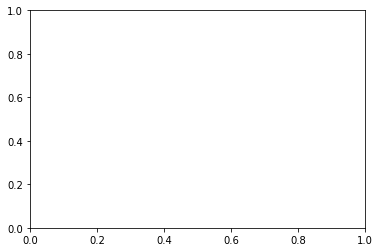

In [20]:

nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size=8)

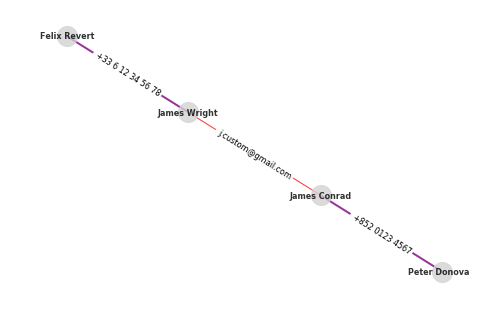

In [371]:
draw(nx.ego_graph(G=G, n=1, radius=3))

### Automated detection of strange patterns

In [360]:
degrees = list(nx.degree(G))

In [378]:
pd.DataFrame([list(d) for d in degrees], columns=['ID', 'degree']).sort_values('degree', ascending=False).head(5)

,ID,degree
1,3,2
2,5,2
0,1,1
3,6,1
4,2,0


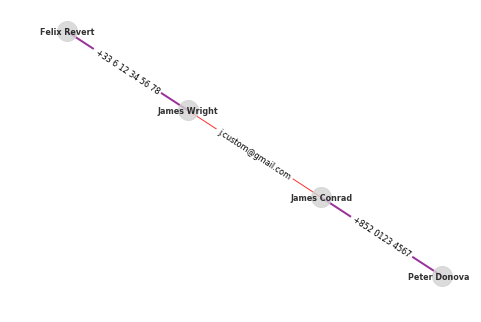

In [384]:
draw(nx.ego_graph(G=G, n=3, radius=2))